## Pontificia Universidad Javeriana

*Autores:*
- Diego Alejandro Jara Rojas  
- Juan Felipe González Quintero  
- Tomás Felipe Guerra Hernández  
- Isaías Acosta Herrera  

*Fecha de Inicio:* 10 - 10 - 2025  
*Fecha de Finalización:* 17 - 10 - 2025  

---

## **Proyecto**
*Análisis de los factores socioeconómicos y delictivos asociados a los arrestos en la ciudad de Nueva York mediante técnicas de procesamiento de Big Data.*

---

## **Problemática**
El aumento de arrestos en ciertos distritos de Nueva York plantea la necesidad de analizar qué factores pueden estar influyendo en esta tendencia.  
Mediante la integración de datos sobre pobreza, criminalidad en escuelas y registros de arrestos, se busca identificar patrones y correlaciones que permitan entender si la desigualdad socioeconómica y la violencia escolar tienen un impacto significativo en las tasas de arrestos.

---

## **Objetivo**
Realizar un análisis exploratorio y predictivo sobre los arrestos en Nueva York a partir de datos públicos de pobreza, crímenes en escuelas y reportes policiales, con el fin de determinar posibles relaciones entre las condiciones sociales y los niveles de criminalidad y detención.

---

## **Metodología**

1. *Importación de datos desde el cluster*  
   Carga de datasets en distintos formatos (CSV, Parquet) provenientes de fuentes oficiales del estado de Nueva York.  

2. *Preprocesamiento y limpieza de datos*  
   Estandarización de valores, manejo de nulos, combinación de bases de datos y normalización de variables.  

3. *Análisis exploratorio de datos (EDA)*  
   Cálculo de medidas estadísticas y visualización de distribuciones para identificar tendencias por distrito, tipo de crimen, nivel de pobreza y número de arrestos.  

4. *Modelado y correlación de variables*  
   Aplicación de modelos estadísticos y de aprendizaje automático (como regresión lineal y modelos de correlación múltiple) para evaluar relaciones entre pobreza, crimen y arrestos.  

5. *Evaluación e interpretación*  
   Análisis de resultados y visualización de patrones espaciales y sociales relevantes para comprender los factores más influyentes en la tasa de arrestos. (Ver documento)

6. *Fuentes de referencia*  
   - Open Data NYC  
   - Department of Education NYC  
   - NYPD Arrest Data Reports  
   - Artículos y estudios previos sobre desigualdad y criminalidad urbana.

# **1.Importación y configuración de recursos**

In [1]:
import sys
print(sys.executable)

/home/estudiante/miniconda3/bin/python3


In [2]:
!which python

~/miniconda3/bin/python


#### Verificamos que estamos utilizando la versión de Python instalado en el cluster mediante Conda.

In [3]:
import os

os.environ["PYSPARK_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"

print("Usando Python en:", os.environ["PYSPARK_PYTHON"])

Usando Python en: /home/estudiante/miniconda3/bin/python3


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

#Bibliotecas especializadas
from pylab import *

In [5]:
#Bibliotecas de Contexto PySpark

#Busqueda e inicializacion para pyspark
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F # Acceso a todas las funciones
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession


In [6]:
### Se crea una sesión para jacer el contexto de procesamiento desde mi Cuota del Cluster
from pyspark import SparkConf
## Configuracion de la cuota
configura = SparkConf().set("spark.scheduler.mode", "FAIR")

## Se levanta la configuración de mi cuota
configura.setAppName("NY_Pobreza_Proyecto")

sparkSPP = SparkSession.builder.config(conf=configura).getOrCreate()
SQLContext(sparkContext=sparkSPP.sparkContext, sparkSession=sparkSPP)

contextoSparkSPP = sparkSPP.sparkContext.getOrCreate()

print("Sesion Cluster: NY_Pobreza_Proyecto")
sparkSPP

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/16 18:25:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Sesion Cluster: NY_Pobreza_Proyecto


# **2.- Carga de datos desde el cluster**

In [7]:
### Como estoy en un servidor que no es mio, y ni siquiera lo he realizado ni IMPLEMENTADO
### Requiero saber que configuración de hardware me han dado a mi cuota de sesión
### Adicional como cientifico que soy, requiero tambien como hacer un cluster para saber todo eso de implementación de un cluster,

cantCPUS = sparkSPP._jsc.sc().getExecutorMemoryStatus().keySet().size()
print(f"Cantidad de CPU's en mi sesion Spark09: {cantCPUS}" )
print(sparkSPP.sparkContext.getConf().getAll())


Cantidad de CPU's en mi sesion Spark09: 1
[('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.app.name', 'NY_Pobreza_Proyecto'), ('spark.driver.host'

### Acceso al Cluster de Almacenamiento (Almacen)

In [8]:
## Se carga el CSV de Pobreza en nueva york como OBJETO DATAFRAME PySpark

### Se empieza a cargar en un objeto dataframe del tipo SPARK los datos CSV
df00 = sparkSPP.read.csv("/almacen/proyecto/NYCgov_Poverty_Measure_Data__2018__20251009.csv", header = True, inferSchema=True)

df00.show(5)

25/10/16 18:25:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-------+-----+----+----+---+---+---+----+----+---+---+----+----+---+---+----+----+---+----+---+---+---+--------+----+-------------+----------+-------------+-------------+--------+-----------+--------+-----------+-------------+---------+-------------+----------+---------------+---------+----------+--------+---------+---------+-------------+---------------+----------+----------------+------------+-------------+------+------+----------+-----------+---------------+--------+--------+--------+--------+---------+---------------+---------+
|SERIALNO|SPORDER|PWGTP|WGTP|AGEP|CIT|REL|SCH|SCHG|SCHL|SEX|ESR|LANX| ENG|MSP|MAR| WKW|WKHP|DIS|JWTR| NP|TEN|HHT|AgeCateg|Boro|CitizenStatus|EducAttain|EST_Childcare|EST_Commuting|EST_EITC|EST_FICAtax|EST_HEAP|EST_Housing|EST_IncomeTax| EST_MOOP|EST_Nutrition|EST_PovGap|EST_PovGapIndex|Ethnicity|FamType_PU|FTPTWork| INTP_adj| MRGP_adj|NYCgov_Income|NYCgov_Pov_Stat|NYCgov_REL|NYCgov_Threshold|Off_Pov_Stat|Off_Threshold|OI_adj|PA_adj|Povunit_ID|Povun

## **3. - Análisis de los Datos obtenidos**
Se presentan datos (csv) ------

- Tipos de datos: coherencia de tipo de datos, transformación.
- Columnas: conocimiento de las columnas, eliminación.
- Análisis de taso nulos o imposibles: conocimiento.

In [9]:
## Conocimiento de las columnas
df00.columns

['SERIALNO',
 'SPORDER',
 'PWGTP',
 'WGTP',
 'AGEP',
 'CIT',
 'REL',
 'SCH',
 'SCHG',
 'SCHL',
 'SEX',
 'ESR',
 'LANX',
 'ENG',
 'MSP',
 'MAR',
 'WKW',
 'WKHP',
 'DIS',
 'JWTR',
 'NP',
 'TEN',
 'HHT',
 'AgeCateg',
 'Boro',
 'CitizenStatus',
 'EducAttain',
 'EST_Childcare',
 'EST_Commuting',
 'EST_EITC',
 'EST_FICAtax',
 'EST_HEAP',
 'EST_Housing',
 'EST_IncomeTax',
 'EST_MOOP',
 'EST_Nutrition',
 'EST_PovGap',
 'EST_PovGapIndex',
 'Ethnicity',
 'FamType_PU',
 'FTPTWork',
 'INTP_adj',
 'MRGP_adj',
 'NYCgov_Income',
 'NYCgov_Pov_Stat',
 'NYCgov_REL',
 'NYCgov_Threshold',
 'Off_Pov_Stat',
 'Off_Threshold',
 'OI_adj',
 'PA_adj',
 'Povunit_ID',
 'Povunit_Rel',
 'PreTaxIncome_PU',
 'RETP_adj',
 'RNTP_adj',
 'SEMP_adj',
 'SSIP_adj',
 'SSP_adj',
 'TotalWorkHrs_PU',
 'WAGP_adj']

#### Descripción de las columnas más importantes
- **AgeCateg:** Categoria de edad [1 Menor de 18 años | 2 De 18 a 64 años | 3 65+ años\].
- **Boro:** Borough de la ciudad de Nueva York [1 Bronx | 2 Brooklyn | 3 Manhattan | 4 Queens | 5 Staten Island\].
- **EducAttain:** Nivel de educación [1 Menos que la secundaria | 2 Título de secundaria | 3 Algunos estudios universitarios | 4 Licenciatura o título superior\] 
- **EST_Housing:** Estimación del ajuste de los ingresos para el subsidio de vivienda [Monto en dólares\]
- **EST_IncomeTax:** Impuestos sobre la renta neta estimados por el gobierno de la ciudad de Nueva York (impuestos pagados, netos de créditos fiscales) [Monto en dólares\]
- **EST_PovGapIndex:** Brecha de la pobreza expresada como proporción del umbral de pobreza [Relación entre los recursos familiares y su umbral de pobreza\]
- **Ethnicity:** Raza/Etnicidad [1 Blanco no hispano | 2 Negro no hispano | 3 Asiático no hispano | 4 Hispano de cualquier raza | 5 Otra raza/grupo étnico\]
- **FamType_PU:** Estructura Familiar de la Unidad de Pobreza [1 Esposo/Esposa + hijo | 2 Esposo/Esposa sin hijos | 3 Hombre soltero + hijo | 4 Mujer soltera + hijo | 5 Jefe de unidad hombre, sin hijos | 6 Jefa de unidad mujer, sin hijos | 7 Individuo no emparentado con otros | 8 Individuo no emparentado solo\]
- **NYCgov_Income:** Ingreso total estimado comparado con el umbral del gobierno de la ciudad de Nueva York para determinar el estado de pobreza [Monto en dólares\]
- **NYCgov_Pov_Stat:** Estado de pobreza teniendo en cuanta el límite de pobreza establecido por el gobierno de la ciudad de Nueva York [1= En pobreza 2= No en pobreza\]
- **Off_Pov_Stat:** Estado de pobreza oficial/federal (teniendo en cuanta el límite de pobreza establecido por todo Estados Unidos en general ) [1= En pobreza 2= No en pobreza\]
- **PreTaxIncome_PU:** Ingresos en efectivo antes de impuestos [Monto en dólares\]
- **AGEP:** Edad de la persona [00 Menor de 1 año | 01 - 99 1 a 99 años\]
- **CIT:** Estado de ciudadanía [1 Nacido en los EE. UU. | 2 Nacido en Puerto Rico, Guam, las Islas Vírgenes de los EE. UU. o las Islas Marianas del Norte | 3 Nacido en el extranjero de padre(s) estadounidense(s) | 4 Ciudadano estadounidense por naturalización | 5 No ciudadano de los EE. UU.\]
- **ENG:** Habilidad para hablar inglés [b N/A (menos de 5 años/habla solo inglés) | 1 Muy bien | 2 Bien | 3 No muy bien | 4 Para nada\]
- **LANX:** Habla idiomas diferentes al inglés [b N/A (menos de 5 años) | 1 Sí, habla otro idioma | 2 No, solo habla inglés\]
- **MSP:** Estado marital [b N/A (edad menor de 15 años) | 1 Actualmente casado, cónyuge presente | 2 Actualmente casado, cónyuge ausente | 3 Viudo | 4 Divorciado | 5 Separado | 6 Nunca se casó\]
- **NP:** Numero de personas en la unidad de alojamiento [00 Unidad vacante | 01 Registro de una persona (una persona en el hogar o cualquier persona en alojamiento colectivo) | 02 - 20 Número de registros de personas (número de personas en el hogar)\]
- **RNTP_adj:** Alquiler mensual, ajustado por el factor de ajuste de ingresos [bbbbb N/A (GQ/unidades vacantes, excepto “en alquiler” y “alquiladas, no ocupadas”/propias o en compra/ocupadas sin pago de alquiler) | 00001 - 99999 1 USD a 9999 USD (Redondeado y codificado en la parte superior)\]
- **SCH:** ¿Esta matriculado? [b N/A (menos de 3) | 1 No, no ha asistido en los últimos 3 meses | 2 Sí, escuela pública o colegio público | 3 Sí, escuela o colegio privado o educación en casa\]
- **SCHG:** Nivel de grado al que asiste [Códigos ACS\]
- **SCHL:** Logros educativos [Códigos ACS\]
- **SEX:** Sexo [1 Hombre | 2 Mujer\]
- **TEN:** Tenencia de la vivienda [b N/A (GQ/vacante) | 1 Propiedad con hipoteca o préstamo (incluye préstamos sobre el valor líquido de la vivienda) | 2 Propiedad libre de gravámenes | 3 Alquilada | 4 Ocupada sin pago de alquiler\]
- **EST_Nutrition:** Ajustes de ingresos combinados relacionados con la nutrición (SNAP, WIC, comidas escolares) estimados por el gobierno de la ciudad de Nueva York [Monto en dólares\]

#### **Estadísticas de los datos:**

In [10]:
# Se presentan las estadísticas de las variables 
for valor in df00.columns:
  df00.describe(valor).show()

+-------+-----------------+
|summary|         SERIALNO|
+-------+-----------------+
|  count|            68273|
|   mean|701952.8149048672|
| stddev|404933.3367096614|
|    min|                1|
|    max|          1400927|
+-------+-----------------+

+-------+------------------+
|summary|           SPORDER|
+-------+------------------+
|  count|             68273|
|   mean| 2.311103950317109|
| stddev|1.5867803645948617|
|    min|                 1|
|    max|                20|
+-------+------------------+

+-------+------------------+
|summary|             PWGTP|
+-------+------------------+
|  count|             68273|
|   mean|120.37427680049214|
| stddev| 88.56635939330491|
|    min|                11|
|    max|              1500|
+-------+------------------+

+-------+------------------+
|summary|              WGTP|
+-------+------------------+
|  count|             68273|
|   mean|116.30480570650184|
| stddev|  82.9845425774654|
|    min|                14|
|    max|           

### Tipos de datos del dataframe

In [11]:
#Tipos de datos
df00.dtypes

[('SERIALNO', 'int'),
 ('SPORDER', 'int'),
 ('PWGTP', 'int'),
 ('WGTP', 'int'),
 ('AGEP', 'int'),
 ('CIT', 'int'),
 ('REL', 'int'),
 ('SCH', 'int'),
 ('SCHG', 'int'),
 ('SCHL', 'int'),
 ('SEX', 'int'),
 ('ESR', 'int'),
 ('LANX', 'int'),
 ('ENG', 'int'),
 ('MSP', 'int'),
 ('MAR', 'int'),
 ('WKW', 'int'),
 ('WKHP', 'int'),
 ('DIS', 'int'),
 ('JWTR', 'int'),
 ('NP', 'int'),
 ('TEN', 'int'),
 ('HHT', 'int'),
 ('AgeCateg', 'int'),
 ('Boro', 'int'),
 ('CitizenStatus', 'int'),
 ('EducAttain', 'int'),
 ('EST_Childcare', 'double'),
 ('EST_Commuting', 'double'),
 ('EST_EITC', 'double'),
 ('EST_FICAtax', 'double'),
 ('EST_HEAP', 'double'),
 ('EST_Housing', 'double'),
 ('EST_IncomeTax', 'double'),
 ('EST_MOOP', 'double'),
 ('EST_Nutrition', 'double'),
 ('EST_PovGap', 'double'),
 ('EST_PovGapIndex', 'double'),
 ('Ethnicity', 'int'),
 ('FamType_PU', 'int'),
 ('FTPTWork', 'int'),
 ('INTP_adj', 'double'),
 ('MRGP_adj', 'double'),
 ('NYCgov_Income', 'double'),
 ('NYCgov_Pov_Stat', 'int'),
 ('NYCgov_REL

Como se pudo observar, todos los datos obtenidos tienen tipos numéricos (int para los que requieren decimales y double para los que si). Esto sucede porque esta base de datos solo usa variables numericas y categóricas, y las variables categóricas estan representadas numéricamente, por lo tanto no hubo necesidad del uso de otro tipos de datos como string.  

**Nota:** Si alguien quiere saber el significado de una variable categorica, solo se va al diccionario de la base de datos y traduce el número al nombre que corresponde.

### **Exploración de los valores nulos**

In [12]:
#Cantidad de valores Nulos o Imposibles
df00.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

[Stage 186:============================>                            (2 + 2) / 4]

+--------+-------+-----+----+----+---+---+---+----+----+---+-----+----+-----+-----+---+-----+----+---+-----+---+---+---+--------+----+-------------+----------+-------------+-------------+--------+-----------+--------+-----------+-------------+--------+-------------+----------+---------------+---------+----------+--------+--------+--------+-------------+---------------+----------+----------------+------------+-------------+------+------+----------+-----------+---------------+--------+--------+--------+--------+-------+---------------+--------+
|SERIALNO|SPORDER|PWGTP|WGTP|AGEP|CIT|REL|SCH|SCHG|SCHL|SEX|  ESR|LANX|  ENG|  MSP|MAR|  WKW|WKHP|DIS| JWTR| NP|TEN|HHT|AgeCateg|Boro|CitizenStatus|EducAttain|EST_Childcare|EST_Commuting|EST_EITC|EST_FICAtax|EST_HEAP|EST_Housing|EST_IncomeTax|EST_MOOP|EST_Nutrition|EST_PovGap|EST_PovGapIndex|Ethnicity|FamType_PU|FTPTWork|INTP_adj|MRGP_adj|NYCgov_Income|NYCgov_Pov_Stat|NYCgov_REL|NYCgov_Threshold|Off_Pov_Stat|Off_Threshold|OI_adj|PA_adj|Povunit_ID|

Con esto se evidencia que, aunque la mayoria de columnas no tienen valores nulos, existen algunas que en tienen bastantes. Esto corresponde a lo mencionado anteriormente en la descripción de columnas, en las que algunas columnas usan el valor nulo para indicar que no aplica (Ej: En estado marital, si es menor de 15 años se le pone que no aplica.)

# **4. Limpieza de datos**

## **Selección de las columnas relevantes**

La base de datos de pobreza contiene bastante información que no es relevante para este estudio, en el que pretendemos encontrar relación entre arrestos y pobreza.

In [13]:
#Se seleccionan las columnas relevantes para este estudio
df01 = df00.select('AGEP','AgeCateg','Boro','EducAttain','SCH','SCHG','SCHL','CIT','Ethnicity','SEX','ENG','LANX','MSP','FamType_PU','NP','EST_Housing',
                   'TEN', 'EST_IncomeTax','EST_PovGapIndex','NYCgov_Income','PreTaxIncome_PU','NYCgov_Pov_Stat','Off_Pov_Stat','RNTP_adj',
                   'EST_Nutrition')
#Se comprueba la correcta creación del nuevo dataframe
df01.show(10)

+----+--------+----+----------+---+----+----+---+---------+---+----+----+---+----------+---+-----------+---+-------------+---------------+-------------+---------------+---------------+------------+---------+-------------+
|AGEP|AgeCateg|Boro|EducAttain|SCH|SCHG|SCHL|CIT|Ethnicity|SEX| ENG|LANX|MSP|FamType_PU| NP|EST_Housing|TEN|EST_IncomeTax|EST_PovGapIndex|NYCgov_Income|PreTaxIncome_PU|NYCgov_Pov_Stat|Off_Pov_Stat| RNTP_adj|EST_Nutrition|
+----+--------+----+----------+---+----+----+---+---------+---+----+----+---+----------+---+-----------+---+-------------+---------------+-------------+---------------+---------------+------------+---------+-------------+
|  31|       2|   2|         4|  1|   0|  22|  1|        4|  2|NULL|   2|  6|         8|  1|  1478.3278|  2|    33580.543|            0.0|    81417.961|      127650.22|              2|           2|      0.0|          0.0|
|  63|       2|   3|         4|  1|   0|  22|  1|        1|  2|NULL|   2|  1|         2|  2|        0.0|  1|    

Las columnas seleccionadas del conjunto de datos de pobreza fueron elegidas con el propósito de construir una caracterización integral de las personas y sus hogares, considerando aspectos demográficos, familiares, educativos, económicos y de localización. En particular:

- **AGEP, AgeCateg, Ethnicity, SEX, CIT, ENG, LANX y MSP:** Permiten conformar un perfil sociodemográfico de la persona, considerando edad, género, etnicidad, estado civil, ciudadanía y dominio del idioma inglés.
- **FamType_PU, NP, TEN:** Permiten describir la estructura y condiciones familiares del hogar, incluyendo el tipo de familia, el número de integrantes y la forma de tenencia de la vivienda.
- **Boro:** Facilita el análisis geográfico al identificar el borough (distrito) de residencia dentro de la ciudad de Nueva York.
- **EducAttain, SCH, SCHG, SCHL:** Permiten conformar un perfil educativo de la persona, reflejando tanto el nivel educativo alcanzado como la matrícula escolar o universitaria.
- **EST_Housing, EST_IncomeTax, NYCgov_Income, PreTaxIncome_PU, RNTP_adj, EST_Nutrition:** Contribuyen a la construcción de un perfil económico, ya que reflejan ingresos, impuestos, gastos en vivienda y acceso a programas de apoyo alimentario.
- **EST_PovGapIndex, NYCgov_Pov_Stat, Off_Pov_Stat:** Permiten evaluar el estado de pobreza de acuerdo con los umbrales establecidos por el gobierno de la ciudad y el gobierno federal, así como la brecha existente entre los recursos familiares y dichos umbrales.

Una vez seleccionadas las columnas, **volvemos a explorar la cantidad de valores nulos** ya que, como se mencionó antes, la mayor parte de los valores nulos se encontraban en columnas que no son relevantes para los fines de este estudio

In [14]:
#Verificar de nuevo valores nulos obtenidos
df01.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+----+--------+----+----------+---+----+----+---+---------+---+-----+----+-----+----------+---+-----------+---+-------------+---------------+-------------+---------------+---------------+------------+--------+-------------+
|AGEP|AgeCateg|Boro|EducAttain|SCH|SCHG|SCHL|CIT|Ethnicity|SEX|  ENG|LANX|  MSP|FamType_PU| NP|EST_Housing|TEN|EST_IncomeTax|EST_PovGapIndex|NYCgov_Income|PreTaxIncome_PU|NYCgov_Pov_Stat|Off_Pov_Stat|RNTP_adj|EST_Nutrition|
+----+--------+----+----------+---+----+----+---+---------+---+-----+----+-----+----------+---+-----------+---+-------------+---------------+-------------+---------------+---------------+------------+--------+-------------+
|   0|       0|   0|      2107|  0|   0|2107|  0|        0|  0|37557|3533|11021|         0|  0|          0|  0|            0|              0|            0|              0|              0|           0|       0|            0|
+----+--------+----+----------+---+----+----+---+---------+---+-----+----+-----+----------+---+---------

## **Estandarización de variables**
Para la estandarización de variables, se miraron cuales se ubicaban en las otras bases de datos para que fueran consistentes. Se llegaron a estas:
1. **Borough:** La variable que se encuentra en las 3 bases de datos es el borough, sin embargo, todos siguen un estandar diferente. Se decidió tomar como estandar principal la categorización por medio de números:
   [1 Bronx | 2 Brooklyn | 3 Manhattan | 4 Queens | 5 Staten Island\].
2. **Sexo:** Se encuentra en esta y en la base de datos de arrestos.
   Para estandarizarla se decidió hacerlo con los números: [1 Hombre | 2 Mujer\].
3. **Categoría de edades:** Al encontrarse en esta y en la base de datos de arrestos, para estandarizar, se decidió tomar los rangos descritos en la base de datos de arrestos, para formar una columna de categoria edad usando la columna AGEP.
    [1 Menor de 18 años | 2 De 18 a 24 años | 3 25 a 44 años| 4 45 a 64 años | 5 65+ años \].

In [15]:
from pyspark.sql.functions import when, col

# Se crea una nueva columna 'AgeCategoryArrest' basada en AGEP
df01 = df01.withColumn(
    "AgeCategoryArrest",
    when(col("AGEP") < 18, 1)  # Menor de 18 años
    .when((col("AGEP") >= 18) & (col("AGEP") <= 24), 2)  # 18 a 24 años
    .when((col("AGEP") >= 25) & (col("AGEP") <= 44), 3)  # 25 a 44 años
    .when((col("AGEP") >= 45) & (col("AGEP") <= 64), 4)  # 45 a 64 años
    .otherwise(5)  # 65+ años
)

# Verificar el resultado
df01.select("AGEP", "AgeCategoryArrest").show(10)

+----+-----------------+
|AGEP|AgeCategoryArrest|
+----+-----------------+
|  31|                3|
|  63|                4|
|  65|                5|
|  68|                5|
|  63|                4|
|  29|                3|
|  25|                3|
|  32|                3|
|  76|                5|
|  46|                4|
+----+-----------------+
only showing top 10 rows



## **Tratamiento de datos nulos**
Con el objetivo de que no existan datos nulos que puedan afectar en el proceso de graficación y análisis, se decide dar tratamiento a los datos nulos de las columnas que las tienen.
Para esto se crea una nueva categoría (0) que tiene el mismo significado de los datos nulos (No aplica) y lo reemplazamos.

In [16]:
# Se reemplaza todos los valores nulos o NaN por 0
df01 = df01.fillna(0)

# Confirmar que se reemplazaron correctamente
df01.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+----+--------+----+----------+---+----+----+---+---------+---+---+----+---+----------+---+-----------+---+-------------+---------------+-------------+---------------+---------------+------------+--------+-------------+-----------------+
|AGEP|AgeCateg|Boro|EducAttain|SCH|SCHG|SCHL|CIT|Ethnicity|SEX|ENG|LANX|MSP|FamType_PU| NP|EST_Housing|TEN|EST_IncomeTax|EST_PovGapIndex|NYCgov_Income|PreTaxIncome_PU|NYCgov_Pov_Stat|Off_Pov_Stat|RNTP_adj|EST_Nutrition|AgeCategoryArrest|
+----+--------+----+----------+---+----+----+---+---------+---+---+----+---+----------+---+-----------+---+-------------+---------------+-------------+---------------+---------------+------------+--------+-------------+-----------------+
|   0|       0|   0|         0|  0|   0|   0|  0|        0|  0|  0|   0|  0|         0|  0|          0|  0|            0|              0|            0|              0|              0|           0|       0|            0|                0|
+----+--------+----+----------+---+----+----+---

# **6. Visualización gráfica de datos**

In [33]:
# Ruta base solo como carpeta
ruta_guardado = '/almacen/proyecto/graficas_proyecto'
os.makedirs(ruta_guardado, exist_ok=True)

### **Etnia sex education**

In [34]:
import pyspark.sql.functions as F

# Agrupar por Ethnicity, SEX y EducAttain
df_grouped = (
    df01.groupBy("Ethnicity", "SEX", "EducAttain")
    .agg(F.count("*").alias("count"))
    .orderBy("Ethnicity", "SEX", "EducAttain")
)

# Mostrar resultados agrupados
df_grouped.show(10)


+---------+---+----------+-----+
|Ethnicity|SEX|EducAttain|count|
+---------+---+----------+-----+
|        1|  1|         0|  389|
|        1|  1|         1| 2427|
|        1|  1|         2| 1770|
|        1|  1|         3| 1910|
|        1|  1|         4| 5549|
|        1|  2|         0|  371|
|        1|  2|         1| 2267|
|        1|  2|         2| 2071|
|        1|  2|         3| 1826|
|        1|  2|         4| 6141|
+---------+---+----------+-----+
only showing top 10 rows



In [35]:
pdf = df_grouped.toPandas()

ethnicity_labels = {
    1: "Blanco no hispano",
    2: "Negro no hispano",
    3: "Asiático no hispano",
    4: "Hispano",
    5: "Otra etnia"
}

sex_labels = {1: "Hombre", 2: "Mujer"}

education_labels = {
    1: "Menos que secundaria",
    2: "Título de secundaria",
    3: "Algunos estudios universitarios",
    4: "Licenciatura o superior"
}

pdf["Ethnicity"] = pdf["Ethnicity"].map(ethnicity_labels)
pdf["SEX"] = pdf["SEX"].map(sex_labels)
pdf["EducAttain"] = pdf["EducAttain"].map(education_labels)


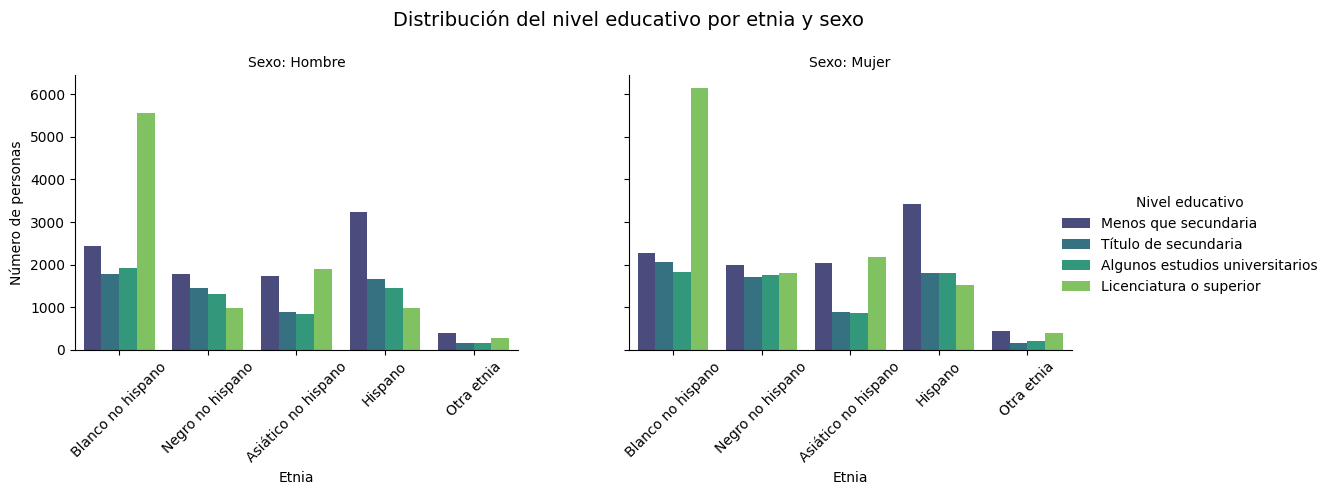

Gráfica guardada en: /almacen/proyecto/graficas_proyecto/grafica_sexo_etnia_por_nivelEducacion.png


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=pdf,
    x="Ethnicity",
    y="count",
    hue="EducAttain",
    col="SEX",
    kind="bar",
    height=5,
    aspect=1,
    palette="viridis"
)

# Títulos y ejes
g.set_titles("Sexo: {col_name}")
g.set_axis_labels("Etnia", "Número de personas")

# Rotar etiquetas del eje X en cada subplot
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)

# Mover la leyenda fuera del gráfico
g._legend.set_bbox_to_anchor((1.05, 0.5))
g._legend.set_title("Nivel educativo")

# Ajustar espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.25, right=0.85)

# Título general
plt.suptitle("Distribución del nivel educativo por etnia y sexo", fontsize=14)

plt.show()

#Guardar
nombre_archivo = "grafica_sexo_etnia_por_nivelEducacion.png"
ruta_completa = os.path.join(ruta_guardado, nombre_archivo)
g.fig.savefig(ruta_completa, dpi=300, bbox_inches='tight')
plt.close(g.fig) 

print(f"Gráfica guardada en: {ruta_completa}")

#### **Análisis:**
Como se puede observar:
1. La mayoria de los censados son blancos no hispanos.
2. La etnia con mayor cantidad de personas que lograron licenciatura o superior, 

### **Nivel pobreza- educattion atained - boro**

In [38]:
import pyspark.sql.functions as F

# Agrupar por pobreza, educación y borough
df_grouped2 = (
    df01.groupBy("NYCgov_Pov_Stat", "EducAttain", "Boro")
    .agg(F.count("*").alias("count"))
    .orderBy("Boro", "EducAttain", "NYCgov_Pov_Stat")
)

df_grouped2.show(10)

+---------------+----------+----+-----+
|NYCgov_Pov_Stat|EducAttain|Boro|count|
+---------------+----------+----+-----+
|              1|         0|   1|  116|
|              2|         0|   1|  223|
|              1|         1|   1| 1264|
|              2|         1|   1| 2601|
|              1|         2|   1|  521|
|              2|         2|   1| 1453|
|              1|         3|   1|  423|
|              2|         3|   1| 1536|
|              1|         4|   1|  205|
|              2|         4|   1| 1464|
+---------------+----------+----+-----+
only showing top 10 rows



In [41]:
pdf2 = df_grouped2.toPandas()

# Diccionarios de etiquetas
pov_labels = {1: "En pobreza", 2: "No en pobreza"}
edu_labels = {
    1: "Menos que secundaria",
    2: "Título de secundaria",
    3: "Algunos estudios universitarios",
    4: "Licenciatura o superior"
}

boro_labels = {
    1: "Bronx",
    2: "Brooklyn",
    3: "Manhattan",
    4: "Queens",
    5: "Staten Island"
}

# Aplicar etiquetas
pdf2["NYCgov_Pov_Stat"] = pdf2["NYCgov_Pov_Stat"].map(pov_labels)
pdf2["EducAttain"] = pdf2["EducAttain"].map(edu_labels)
pdf2["Boro"] = pdf2["Boro"].map(boro_labels)


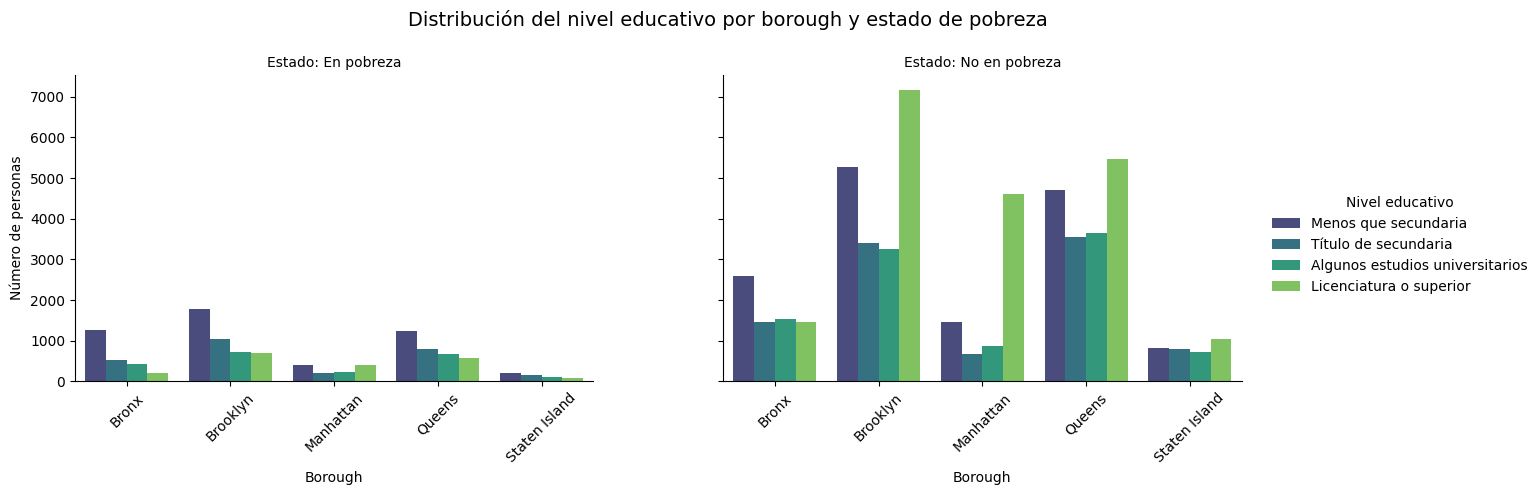

 Gráfica guardada en: /almacen/proyecto/graficas_proyecto/grafica_educacion_pobreza_por_borough.png


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns


g = sns.catplot(
    data=pdf2,
    x="Boro",
    y="count",
    hue="EducAttain",
    col="NYCgov_Pov_Stat",
    kind="bar",
    height=5,
    aspect=1.2,
    palette="viridis"
)

g.set_titles("Estado: {col_name}")
g.set_axis_labels("Borough", "Número de personas")

# Rotar etiquetas X
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)

# Mover la leyenda fuera del gráfico
g._legend.set_bbox_to_anchor((1.05, 0.5))
g._legend.set_title("Nivel educativo")

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.25, right=0.85)
plt.suptitle("Distribución del nivel educativo por borough y estado de pobreza", fontsize=14)

plt.show()

# Guardar la figura
nombre_archivo = "grafica_educacion_pobreza_por_borough.png"
ruta_completa = os.path.join(ruta_guardado, nombre_archivo)
g.fig.savefig(ruta_completa, dpi=300, bbox_inches='tight')
plt.close(g.fig)  

print(f" Gráfica guardada en: {ruta_completa}")

### **Leer Proyecto Escuelas**

In [47]:
df_escuelas = sparkSPP.read.parquet("/almacen/proyecto/parquet/df_crimenesEscuela.parquet")
df_escuelas.show(5)

+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
|Borough|Major N|Oth N|NoCrim N|Prop N|Vio N|AvgOfMajor N|AvgOfOth N|AvgOfNoCrim N|AvgOfProp N|AvgOfVio N|
+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
|      3|    N/A|  N/A|     N/A|   N/A|  N/A|         N/A|       N/A|          N/A|        N/A|       N/A|
|      3|      0|    0|       3|     0|    0|        0.25|      0.88|         1.69|       0.57|      0.45|
|      2|      1|    1|       0|     2|    0|        0.38|      1.52|         3.88|       0.83|      0.91|
|      4|    N/A|  N/A|     N/A|   N/A|  N/A|         N/A|       N/A|          N/A|        N/A|       N/A|
|      3|    N/A|  N/A|     N/A|   N/A|  N/A|         N/A|       N/A|          N/A|        N/A|       N/A|
+-------+-------+-----+--------+------+-----+------------+----------+-------------+-----------+----------+
only showing top 5 rows



[('Borough', 'int'),
 ('Major N', 'string'),
 ('Oth N', 'string'),
 ('NoCrim N', 'string'),
 ('Prop N', 'string'),
 ('Vio N', 'string'),
 ('AvgOfMajor N', 'string'),
 ('AvgOfOth N', 'string'),
 ('AvgOfNoCrim N', 'string'),
 ('AvgOfProp N', 'string'),
 ('AvgOfVio N', 'string')]

In [60]:
# === JOIN entre df_escuelas (Borough) y df01 (Boro) ===
df_join = df_escuelas.join(df01, df_escuelas.Borough == df01.Boro, how="inner")

# Seleccionar columnas relevantes
df_comparacion = df_join.select("Borough", "Major N", "CIT")

# Convertir a Pandas para graficar
pdf_join = df_comparacion.toPandas()

# Reestructurar los datos para graficar (melt)
pdf_melt = pdf_join.melt(
    id_vars=["Borough"],
    value_vars=["Major N", "CIT"],
    var_name="Indicador",
    value_name="Valor"
)

# === GRAFICAR ===
g = sns.catplot(
    data=pdf_melt,
    x="Borough",
    y="Valor",
    hue="Indicador",
    kind="bar",
    height=5,
    aspect=1.2,
    palette="viridis"
)

# Etiquetas y títulos
g.set_axis_labels("Borough", "Valor")
g.set_titles("Comparación Crímenes Mayores (Escuelas) vs CIT (Pobreza)")

# Rotar etiquetas del eje X
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)

# Mover la leyenda fuera del gráfico
g._legend.set_bbox_to_anchor((1.05, 0.5))
g._legend.set_title("Indicador")

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.25, right=0.85)
plt.suptitle("Comparación de Crímenes Mayores en Escuelas y CIT por Borough", fontsize=14)

# === GUARDAR LA FIGURA ===
ruta_guardado = "/almacen/proyecto/graficas"
os.makedirs(ruta_guardado, exist_ok=True)
nombre_archivo = "comparacion_majorN_cit_por_borough.png"
ruta_completa = os.path.join(ruta_guardado, nombre_archivo)

g.fig.savefig(ruta_completa, dpi=300, bbox_inches='tight')
plt.close(g.fig)

print(f"✅ Gráfica guardada en: {ruta_completa}")

25/10/16 21:04:20 ERROR Utils: uncaught error in thread spark-listener-group-appStatus, stopping SparkContext
java.lang.OutOfMemoryError: GC overhead limit exceeded
25/10/16 21:04:20 ERROR Utils: throw uncaught fatal error in thread spark-listener-group-appStatus
java.lang.OutOfMemoryError: GC overhead limit exceeded
Exception in thread "spark-listener-group-appStatus" java.lang.OutOfMemoryError: GC overhead limit exceeded


Py4JJavaError: An error occurred while calling o1472.collectToPython.
: java.lang.OutOfMemoryError: GC overhead limit exceeded
